In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [2]:
data_dir = pathlib.Path('Data')
RESULT            = pathlib.Path('Model\Result')
SAVED_MODEL       = pathlib.Path('Model\Saved Model')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 299
BATCH_SIZE = 32

def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          data_dir,  
          target_size=(IMG_SIZE,IMG_SIZE),  
          batch_size=32,
          class_mode='categorical',
          shuffle=True,
          seed=42,            # IMPORTANT
          subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(
          data_dir,
          target_size=(IMG_SIZE,IMG_SIZE),
          batch_size=32,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=42,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [4]:
train_generator, validation_generator = generator_augmentation_maker()

Found 432 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


In [5]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))

# for images, labels in train_generator(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i]/255)   
#     plt.title(train_generator.class_indices[labels[i]])
#     plt.axis("off")

In [6]:
base_model=keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False
)

In [7]:
# Freeze the base model
base_model.trainable = False

inputs = keras.Input(shape=(224,224,3))
x=keras.applications.mobilenet_v3.preprocess_input(inputs)
x=base_model(x,training=False)
x=keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
modelX=keras.Model(inputs,outputs)
modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 1,535,093
Trainable params: 5,125
Non-trainable params: 1,529,968
_________________________________________________________________


In [8]:
modelX.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:

callback = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4),
            ModelCheckpoint(monitor='val_loss', filepath=RESULT/'model_2.h5', save_weights_only=False, save_best_only=True, verbose=1)]

In [10]:
init_epochs=20

history = modelX.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=init_epochs,
                    callbacks = callback)

Epoch 1/20
14/14 [==============================] - 22s 640ms/step - loss: 1.1967 - accuracy: 0.5787 - val_loss: 1.0192 - val_accuracy: 0.6415

Epoch 00001: val_loss improved from inf to 1.01921, saving model to Model\Result\model_2.h5


C:\Users\congh\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
14/14 [==============================] - 9s 658ms/step - loss: 0.6016 - accuracy: 0.8704 - val_loss: 0.5773 - val_accuracy: 0.8679

Epoch 00002: val_loss improved from 1.01921 to 0.57735, saving model to Model\Result\model_2.h5
Epoch 3/20
14/14 [==============================] - 7s 487ms/step - loss: 0.3498 - accuracy: 0.9282 - val_loss: 0.4169 - val_accuracy: 0.8868

Epoch 00003: val_loss improved from 0.57735 to 0.41687, saving model to Model\Result\model_2.h5
Epoch 4/20
14/14 [==============================] - 7s 495ms/step - loss: 0.2575 - accuracy: 0.9491 - val_loss: 0.3040 - val_accuracy: 0.8962

Epoch 00004: val_loss improved from 0.41687 to 0.30401, saving model to Model\Result\model_2.h5
Epoch 5/20
14/14 [==============================] - 7s 473ms/step - loss: 0.1996 - accuracy: 0.9838 - val_loss: 0.2151 - val_accuracy: 0.9434

Epoch 00005: val_loss improved from 0.30401 to 0.21512, saving model to Model\Result\model_2.h5
Epoch 6/20
14/14 [==========================

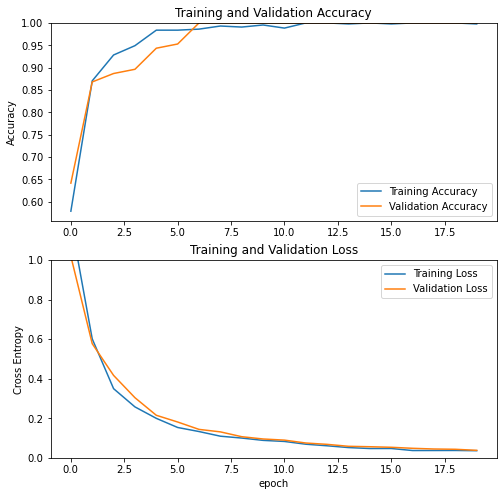

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  235


In [13]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 225

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 1,535,093
Trainable params: 595,973
Non-trainable params: 939,120
_________________________________________________________________


In [14]:
init_epochs = 20
fine_tune_epochs = 15
total_epochs = init_epochs + fine_tune_epochs

history_fine = modelX.fit(train_generator, 
                         validation_data=validation_generator,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callback)



Epoch 21/35
14/14 [==============================] - 12s 541ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 1.0000

Epoch 00021: val_loss improved from 0.03780 to 0.03639, saving model to Model\Result\model_2.h5
Epoch 22/35
14/14 [==============================] - 7s 515ms/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 1.0000

Epoch 00022: val_loss improved from 0.03639 to 0.03601, saving model to Model\Result\model_2.h5
Epoch 23/35
14/14 [==============================] - 7s 476ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 1.0000

Epoch 00023: val_loss improved from 0.03601 to 0.03494, saving model to Model\Result\model_2.h5
Epoch 24/35
14/14 [==============================] - 7s 508ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 1.0000

Epoch 00024: val_loss improved from 0.03494 to 0.03399, saving model to Model\Result\model_2.h5
Epoch 25/35
14/14 [====================

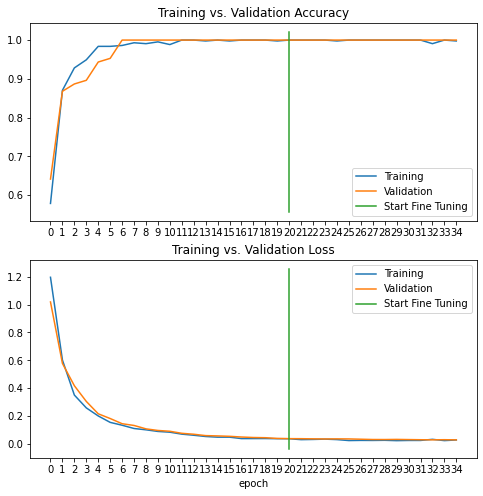

In [15]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
modelX.evaluate(validation_generator)

4/4 [==============================] - 0s 48ms/step - loss: 0.0275 - accuracy: 1.0000


[0.027548016980290413, 1.0]

In [17]:
model_predict=modelX

C:\Users\congh\AppData\Local\Temp/ipykernel_2324/3710493264.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


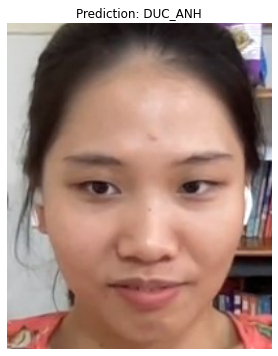

In [18]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model_predict.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

# TEST with your photo
image_path='Predict\Screenshot 2021-11-28 160952.jpg'
predict(model_predict, image_path, 224)

In [19]:
validation_generator.class_indices

{'Duc_Anh': 0, 'Hang': 1, 'Hoi': 2, 'Ngoc': 3, 'Yen': 4}

In [20]:
ground_truth = validation_generator.classes
ground_truth[:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [21]:
filenames = validation_generator.filenames
filenames

['Duc_Anh\\IMG_20211128_085817.jpg',
 'Duc_Anh\\IMG_20211128_085818.jpg',
 'Duc_Anh\\IMG_20211128_085819.jpg',
 'Duc_Anh\\IMG_20211128_085820.jpg',
 'Duc_Anh\\IMG_20211128_085822.jpg',
 'Duc_Anh\\IMG_20211128_085824.jpg',
 'Duc_Anh\\IMG_20211128_085825.jpg',
 'Duc_Anh\\IMG_20211128_085826.jpg',
 'Duc_Anh\\IMG_20211128_085827.jpg',
 'Duc_Anh\\IMG_20211128_085828.jpg',
 'Duc_Anh\\IMG_20211128_085829.jpg',
 'Duc_Anh\\IMG_20211128_085831.jpg',
 'Duc_Anh\\IMG_20211128_085833.jpg',
 'Duc_Anh\\IMG_20211128_085834.jpg',
 'Duc_Anh\\IMG_20211128_085835.jpg',
 'Duc_Anh\\IMG_20211128_085837.jpg',
 'Duc_Anh\\IMG_20211128_085838.jpg',
 'Duc_Anh\\IMG_20211128_085839.jpg',
 'Duc_Anh\\IMG_20211128_085839_1.jpg',
 'Duc_Anh\\IMG_20211128_085840.jpg',
 'Duc_Anh\\IMG_20211128_085841.jpg',
 'Duc_Anh\\IMG_20211128_085842.jpg',
 'Hang\\013238 - Copy.jpg',
 'Hang\\013238.jpg',
 'Hang\\013244 - Copy.jpg',
 'Hang\\013244.jpg',
 'Hang\\013246.jpg',
 'Hang\\013247.jpg',
 'Hang\\013248.jpg',
 'Hang\\013249.jpg',
 '

In [22]:
predictions = modelX.predict(validation_generator)
pred_indices = np.argmax(predictions,axis=1)

img_paths = list(map(lambda x: str(data_dir/x), filenames))  # Full path

In [23]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_indices, target_names=list(validation_generator.class_indices.keys())))

              precision    recall  f1-score   support

     Duc_Anh       1.00      1.00      1.00        22
        Hang       1.00      1.00      1.00        21
         Hoi       1.00      1.00      1.00        22
        Ngoc       1.00      1.00      1.00        20
         Yen       1.00      1.00      1.00        21

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



In [24]:
print(validation_generator.class_indices)

{'Duc_Anh': 0, 'Hang': 1, 'Hoi': 2, 'Ngoc': 3, 'Yen': 4}


In [25]:
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:], '\n')

ground_truth = validation_generator.classes
print(len(ground_truth))
ground_truth

106
['Duc_Anh\\IMG_20211128_085817.jpg', 'Duc_Anh\\IMG_20211128_085818.jpg', 'Duc_Anh\\IMG_20211128_085819.jpg', 'Duc_Anh\\IMG_20211128_085820.jpg', 'Duc_Anh\\IMG_20211128_085822.jpg', 'Duc_Anh\\IMG_20211128_085824.jpg', 'Duc_Anh\\IMG_20211128_085825.jpg', 'Duc_Anh\\IMG_20211128_085826.jpg', 'Duc_Anh\\IMG_20211128_085827.jpg', 'Duc_Anh\\IMG_20211128_085828.jpg', 'Duc_Anh\\IMG_20211128_085829.jpg', 'Duc_Anh\\IMG_20211128_085831.jpg', 'Duc_Anh\\IMG_20211128_085833.jpg', 'Duc_Anh\\IMG_20211128_085834.jpg', 'Duc_Anh\\IMG_20211128_085835.jpg', 'Duc_Anh\\IMG_20211128_085837.jpg', 'Duc_Anh\\IMG_20211128_085838.jpg', 'Duc_Anh\\IMG_20211128_085839.jpg', 'Duc_Anh\\IMG_20211128_085839_1.jpg', 'Duc_Anh\\IMG_20211128_085840.jpg', 'Duc_Anh\\IMG_20211128_085841.jpg', 'Duc_Anh\\IMG_20211128_085842.jpg', 'Hang\\013238 - Copy.jpg', 'Hang\\013238.jpg', 'Hang\\013244 - Copy.jpg', 'Hang\\013244.jpg', 'Hang\\013246.jpg', 'Hang\\013247.jpg', 'Hang\\013248.jpg', 'Hang\\013249.jpg', 'Hang\\013252.jpg', 'Hang\\

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [26]:
predictions = modelX.predict(validation_generator)

In [27]:
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:], '\n')

ground_truth = validation_generator.classes
print(len(ground_truth))
ground_truth

106
['Duc_Anh\\IMG_20211128_085817.jpg', 'Duc_Anh\\IMG_20211128_085818.jpg', 'Duc_Anh\\IMG_20211128_085819.jpg', 'Duc_Anh\\IMG_20211128_085820.jpg', 'Duc_Anh\\IMG_20211128_085822.jpg', 'Duc_Anh\\IMG_20211128_085824.jpg', 'Duc_Anh\\IMG_20211128_085825.jpg', 'Duc_Anh\\IMG_20211128_085826.jpg', 'Duc_Anh\\IMG_20211128_085827.jpg', 'Duc_Anh\\IMG_20211128_085828.jpg', 'Duc_Anh\\IMG_20211128_085829.jpg', 'Duc_Anh\\IMG_20211128_085831.jpg', 'Duc_Anh\\IMG_20211128_085833.jpg', 'Duc_Anh\\IMG_20211128_085834.jpg', 'Duc_Anh\\IMG_20211128_085835.jpg', 'Duc_Anh\\IMG_20211128_085837.jpg', 'Duc_Anh\\IMG_20211128_085838.jpg', 'Duc_Anh\\IMG_20211128_085839.jpg', 'Duc_Anh\\IMG_20211128_085839_1.jpg', 'Duc_Anh\\IMG_20211128_085840.jpg', 'Duc_Anh\\IMG_20211128_085841.jpg', 'Duc_Anh\\IMG_20211128_085842.jpg', 'Hang\\013238 - Copy.jpg', 'Hang\\013238.jpg', 'Hang\\013244 - Copy.jpg', 'Hang\\013244.jpg', 'Hang\\013246.jpg', 'Hang\\013247.jpg', 'Hang\\013248.jpg', 'Hang\\013249.jpg', 'Hang\\013252.jpg', 'Hang\\

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [28]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)


In [29]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(str(data_dir) + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

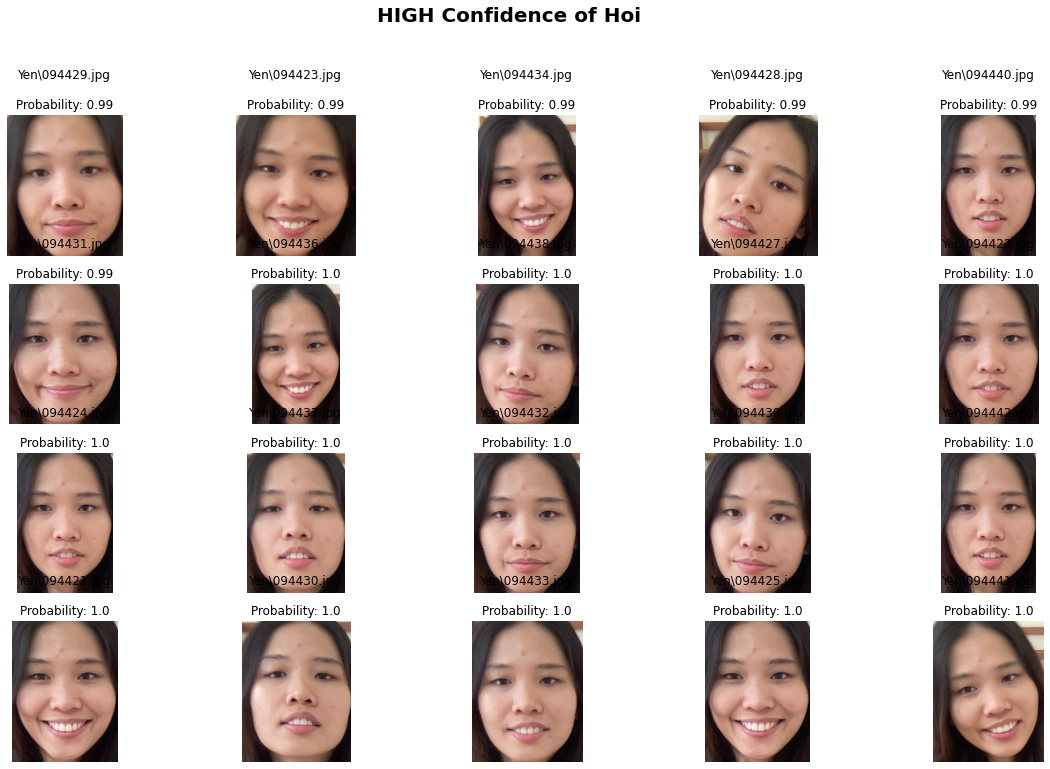

In [30]:
message = 'HIGH Confidence of Hoi'
highest_confident_Hoi_images = get_images_with_sorted_probabilities(prediction_table,False, 4, 20, False)
display(highest_confident_Hoi_images, message)

In [31]:
# plotting functions
def get_img_array(img_path, img_size):
    # `img` is a PIL image
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size)) # load and resize
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # array = preprocess_input(array)     # comment this line if model includes a preprocessing layer
    return array

def plot_image_with_pred(img_path, model, labels, img_size=224):
    # display part
    img = Image.open(img_path)
    img =  img.resize((img_size,img_size))   # resize to mimic model's input
    img = np.array(img)
    plt.imshow(img)
    # prediction part
    img_array = get_img_array(img_path, img_size)
    preds = model.predict(img_array)
    plt.title(f'Prediction: {labels[preds.argmax(axis=1)[0]]}, with {round(preds.max()*100,2)}%')
    return img_array

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, base_model_idx, pretrained=True):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    if pretrained:
        last_conv_layer = model.layers[base_model_idx].get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.layers[base_model_idx].inputs, last_conv_layer.output)
    else:
        last_conv_layer = model.get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

        
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in classifier_layer_names:
      try:
          x = model.get_layer(layer_name)(x)
      except:
          x = model.layers[base_model_idx].get_layer(layer_name)(x)  
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index] # the f function

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# We load the original image
def plot_with_heatmap(img_path, heatmap, img_size=224):
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap  + img*0.6
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    fig, axes = plt.subplots(2, 1, figsize=(10,10))
    step = img_size//7
    axes[0].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[0].imshow(jet_heatmap.astype(int))
    axes[1].set_xticks([x*step for x in range(1,7)])
    axes[0].set_yticks([x*step for x in range(1,7)])
    axes[1].imshow(superimposed_img)
    

In [33]:
modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 1,535,093
Trainable params: 595,973
Non-trainable params: 939,120
_________________________________________________________________


In [34]:
modelX.layers[-4].summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [35]:
tf.keras.utils.plot_model(modelX.layers[-4], show_shapes=True)
# restored_model.layers[3].

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
modelX.layers[-4].layers[-5:]

In [37]:
# IMPORTANT
base_model_idx = -4  # <<<<<
last_conv_idx = -5  # <<<<<

last_conv_layer_name = modelX.layers[base_model_idx].layers[last_conv_idx].name # destination layer
the_rest_names = [i.name for i in modelX.layers[base_model_idx].layers[last_conv_idx+1:]] + [j.name for j in modelX.layers[(base_model_idx+1):]]

# CHECK
print(last_conv_layer_name, '\n')
print(the_rest_names)

Conv_2 

['tf.__operators__.add_27', 're_lu_32', 'tf.math.multiply_27', 'multiply_18', 'global_average_pooling2d_1', 'dropout', 'dense']


In [38]:
def display_everything(path, last_conv_layer_name, the_rest_names, base_model_idx):
  img_path = path
  
  img_array = plot_image_with_pred(img_path, modelX,labels=list(train_generator.class_indices.keys()))
  
  heatmap = make_gradcam_heatmap(img_array, modelX, 
                                last_conv_layer_name, 
                                the_rest_names,
                                base_model_idx)
  
  plot_with_heatmap(img_path,heatmap)

In [39]:
wrong_pred_paths = np.array(img_paths)[(pred_indices != ground_truth)]

print("Total wrong predictions:", len(wrong_pred_paths), '\n')
wrong_pred_paths

Total wrong predictions: 0 



array([], dtype='<U38')

In [40]:
from PIL import Image
def plot_images(img_paths, message, img_size=224):
    plt.figure(figsize=(20, 20))
    columns = 4
    for i, img_path in enumerate(img_paths):
        # predict
        img_array = get_img_array(img_path, img_size)
        predictions = restored_model.predict(img_array)

        # setup
        ax = plt.subplot(len(img_paths) / columns + 1, columns, i + 1)
        ax.set_title(img_paths[i].split("/")[-1] + "\n" +
                     "\nProbability: " + str(float("{0:.1f}".format(predictions.max()*100))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        
        # show
        img = Image.open(img_path)
        img = np.array(img)
        plt.imshow(img)

In [41]:
plot_images(wrong_pred_paths[:10], "Wrong predictions")

<Figure size 1440x1440 with 0 Axes>

In [43]:
import pandas as pd
def get_images_df_from_source(data_source_path):
  """
  This function will return a dataframe with image path, width, height, and file size
  in given data source path
  """
  all_images = [str(x) for x in data_source_path.glob('*/*') if x.parent.name in label_names and x.is_file()]

  all_images_with_size = []
  count = 0
  for image in all_images:

    fsize = os.path.getsize(image)
    im = Image.open(image)
    all_images_with_size.append([image, im.width, im.height, fsize])
    count += 1

    if(count % 100):
      print('Alreay computed {} images'.format(count))

  print('total images:', len(all_images_with_size))
  
  df = pd.DataFrame(all_images_with_size, columns=['filename', 'width', 'height', 'filesize'])
  
  return df

In [46]:
import os
def preprocess_images(path_src, path_dest, verbose=0):
  """
  This function will preprocess all images inside source folder and copy to destination folder
  Parameters:
  - verbose: print out the progress. 0 or 1.
  - path_src: the path of source folder.
  - path_dest: the path of destination folder.
  """
  
  all_images_for_resizing = [str(x) for x in path_src.glob('*/*') if x.parent.name in label_names and x.is_file()]

  for image_path in all_images_for_resizing:

    image = Image.open(image_path)

    # check if image is PNG
    if len(image.split()) > 3:
      #convert PNG to JPEG
      image = image.convert('RGB')

    # check destination folders
    if not path_dest.is_dir():
      # destination train folder is not existed, create one
      os.mkdir(path_dest)

    # get the file name
    image_splits = image_path.rsplit('/', 2)
    dest_folder = pathlib.Path(os.path.join(path_dest, image_splits[1]))

    # if destination label folder not existed, then create one
    if not dest_folder.is_dir():
      os.mkdir(dest_folder)

    # set destination file name
    dest_filename = pathlib.Path(os.path.join(image_path.rsplit('/', 2)[-2], image_path.rsplit('/', 2)[-1]))
    # set new destination
    dest_filename = pathlib.Path(os.path.join(path_dest, dest_filename))

    # image resizing process
    if image.width > 500 or image.height > 500:
      # set the new dimensions
      if (image.width > image.height): # landscape image
        new_size = (int(500*(image.width/image.height)), 500 )

      else: # portrait image
         new_size = (500, int(500*(image.width/image.height)))

      output = image.resize(new_size)

      # save all resized file to new destination
      if not dest_filename.is_file():
        output.save(dest_filename)

    else: # now working on the rest images
      if not dest_filename.is_file():
        image.save(dest_filename)
    
    if verbose == 1:
      print(dest_filename)
      print('current size: ({}, {})'.format(image.width, image.height))
      print('new size:', new_size)

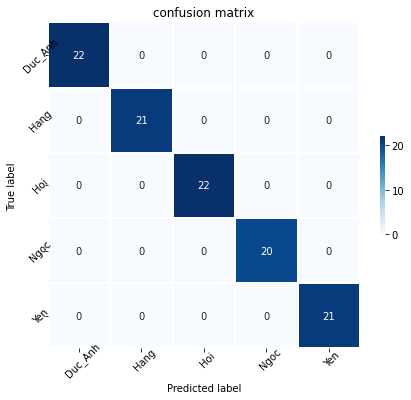

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
## plot confusion matrix
y_preds = pred_indices
y_trues = ground_truth
c_m = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(c_m, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(validation_generator.class_indices.keys()),
    yticklabels=list(validation_generator.class_indices.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()